In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


import hydra
from typing import Optional
from collections.abc import Callable
from omegaconf import OmegaConf, DictConfig

from data_module.visualize.vis_lightning_data_module import DataModule
from hydra import initialize, initialize_config_module, initialize_config_dir, compose

In [8]:
def setup(cfg):

    cfg.loader.batch_size = 1

    if 'split' not in cfg:
        cfg.split = 'val'

    if 'shuffle' not in cfg:
        cfg.shuffle = False
        
def setup_config(cfg: DictConfig, override: Optional[Callable] = None):

    OmegaConf.set_struct(cfg, False)
    OmegaConf.resolve(cfg)
    OmegaConf.set_struct(cfg, True)


def merge_rgbs(imgs):

    fl = np.transpose(imgs[0], (1,2,0))
    ff = np.transpose(imgs[1], (1,2,0))
    fr = np.transpose(imgs[2], (1,2,0))

    front = np.hstack([fl, ff, fr])

    bl = np.transpose(imgs[5], (1,2,0))
    bf = np.transpose(imgs[4], (1,2,0))
    br = np.transpose(imgs[3], (1,2,0))

    back = np.hstack([bl, bf, br])

    whole = np.vstack([front, back])

    return whole

def vis_gt(bev):
    bev = np.transpose(bev, (1, 2, 0))
    area = bev[:,:,0] + bev[:,:,1]
    divider = bev[:,:,2] + bev[:,:,3]
    vehicle = bev[:,:,4] + bev[:,:,5] + bev[:,:,6] + bev[:,:,7]

    h, w = area.shape
    vis = np.full((h, w, 3), 255, dtype='uint8')

    
    for i, bibev in enumerate([area, divider, vehicle]):
    # for i, bibev in enumerate([area, vehicle]):
        vis[bibev!=0,:] = mapping[i]
    
    vis[95:105, 98:102, :] = (255, 0, 0)

    return vis

In [9]:
# *  config setup  * #
CONFIG_PATH = '/usr/src/CV_For_Autonomous_Driving/config'

with initialize_config_dir(config_dir=CONFIG_PATH):
    cfg = compose(config_name='default_config_debug2.yaml')
    
setup_config(cfg, setup)


# dataset list 만드는 test
DM = DataModule(cfg.data, cfg.loader)

split = 'val'
data_cfg = DM.data_cfg
datasets = DM.get_data(split=split,
                            **data_cfg)

# datasets = DM.get_dataset_bevdepth(split=split,
#                             **data_cfg)

print(f'In {split} dataset, {len(datasets)} scenes are included.')


# dataset init test
# total = 0
# for dataset in datasets:
#     total += len(dataset)

# print(f'nuscenes train has {total} data samples')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  after removing the cwd from sys.path.


/usr/src/CV_For_Autonomous_Driving/data_module/visualize /usr/src/CV_For_Autonomous_Driving/data_module
{'dataset': 'nuscenes_generated', 'cameras': [[0, 1, 2, 3, 4, 5]], 'label_indices': [[0, 1]], 'bev': {'h': 200, 'w': 200, 'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}, 'augment': 'none', 'image': {'h': 224, 'w': 480, 'top_crop': 46}}
In val dataset, 150 scenes are included.


In [10]:
# dataset __getitem__ test
data = datasets[0].__getitem__(10) #! Dataset output LIST 임
# for k, v in data.items():
#     print(f'{k}: {v.shape}')

### Visualization: depth ground truth

[8.02416134 8.0397501  8.04069233 8.0579958  8.07276821 8.07279205
 8.08466816 8.09858418 8.10464191 8.11882401 8.1335783  8.1353035
 8.15009117 8.16484547 8.16578293 8.18206978 8.19754982 8.2003088
 8.21542072 8.23019123 8.23355103 8.24413872 8.26654816 8.26948261
 8.27511978 8.2967329  8.29873085 8.3076458  8.33274269 8.33301926
 8.34179592 8.35979366 8.3654623  8.37296009 8.39527321 8.40019798
 8.40744114 8.42714596 8.43342686 8.43389225 8.45671368 8.46533966
 8.47276306 8.49595737 8.49748898 8.50390053 8.5276289  8.52780151
 8.53447628 8.55216789 8.55995655 8.5694046  8.59602356 8.59784889
 8.60775948 8.62603092 8.62711525 8.63859367 8.65858936 8.66045666
 8.67278576 8.68656826 8.70126629 8.72338295 8.72723866 8.76016521
 8.76592064 8.79165077 8.79934502 8.82291985 8.82584476 8.85385609
 8.85804844 8.89192486 8.89866257 8.92483425 8.93282986 8.95495796
 8.96306038 8.98855209 9.00229454 9.02365589 9.03195763 9.05856037
 9.06757736 9.09377766 9.10041142 9.12623882 9.13110161 9.156554

(-0.5, 504.025, 235.225, -0.5)

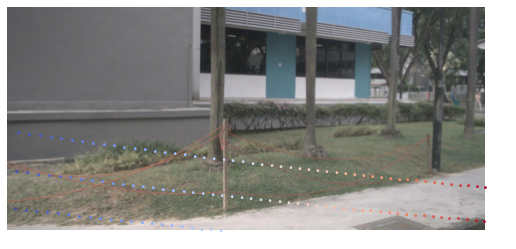

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 16))

# fig.canvas.set_window_title(sample_token)
img = np.transpose(data['image'][0].numpy(), (1,2,0))
depth = data['depth'][0].numpy()
# debug_d = data['debug_d'][0]

h, w = depth.shape

x = np.linspace(0, w, w)
y = np.linspace(0, h, h)
xs, ys = np.meshgrid(x, y)

xs_flat = xs.flatten()
ys_flat = ys.flatten()
depth_flat = depth.flatten()

mask = depth_flat > 1e-5
xs_filter = xs_flat[mask]
ys_filter = ys_flat[mask]
depth_filter = depth_flat[mask]

print(np.unique(depth_filter))

ax.imshow(img)
ax.scatter(xs_filter, ys_filter, c=depth_filter, s=3, cmap='coolwarm') 


ax.axis('off')

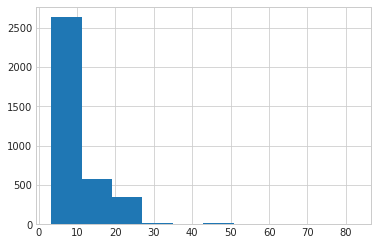

In [6]:
plt.hist(depth_filter)
plt.show()

### Visualization: 3d bbox ground truth & BEV segmentation map

In [8]:
# 3d bbox 
mapping = {0: (255, 153, 51),
            1: (0, 128, 255),
            2: (0, 0, 255)}

bev_map = np.full((200, 200, 3), 255)

gt_bbox = data['gt_box']
gt_cls = data['gt_label'].numpy()

# merge images
merged_imgs = merge_rgbs(data['image'].numpy())
# bev: torch.Size([200, 200, 12])
bev = vis_gt(data['bev'].numpy())

np.unique(data['bev'].numpy())

len(data['gt_box'])


37

In [9]:
cls_mapping = {}
for i in range(10):
    cls_mapping[i] = np.random.rand((3))*255

In [10]:
from data_module.dataset.utils import *
#(0,0), top left
bev_cfg = {'h': 200, 'w': 200, 
                    'h_meters': 100.0, 'w_meters': 100.0, 'offset': 0.0}
meter2pix = get_bev_meter2pix_matrix(bev_cfg)

In [11]:
import matplotlib.patches as patches
bev_map = np.full((200, 200, 3), 255)
for i in range(len(gt_bbox)):
    l, w, h = gt_bbox[i][3:6] 

    # 3D bounding box corners. (Convention: x points forward, y to the left, z up.)
    x_corners = l / 2 * np.array([1,  1,  1,  1, -1, -1, -1, -1])
    y_corners = w / 2 * np.array([1, -1, -1,  1,  1, -1, -1,  1])
    z_corners = h / 2 * np.array([1,  1, -1, -1,  1,  1, -1, -1])
    corners = np.vstack((x_corners, y_corners, z_corners))

    # Rotate
    #! 필수!! 
    # print(gt_bbox[i][6])
    corners = np.dot(gt_bbox[i][6].rotation_matrix, corners)

    # Translate
    x, y, z = gt_bbox[i][:3]
    corners[0, :] = corners[0, :] + x
    corners[1, :] = corners[1, :] + y
    corners[2, :] = corners[2, :] + z
    # print('corners', corners.shape)
    p =corners[:, [2, 3, 7, 6]]


    
    gt_box = gt_bbox[i]


    h, w = 200,200
    V = meter2pix 
    S = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
    ])


    p = np.pad(p, ((0, 1), (0, 0)), constant_values=1.0)     
    p = V @ S @ p  
    if (p[0][0] < 0 or p[0][0]> 200) or (p[0][3] < 0 or p[0][3] > 200) \
        or (p[1][0] < 0 or p[1][0]  > 200) or (p[1][3]  < 0 or p[1][3] > 200):
        continue 

    bbox = p[:2, :4]
    bev_map = cv2.fillPoly(bev_map.astype(np.int32), [bbox.round().astype(np.int32).T], 1, cv2.LINE_8)

(-0.5, 199.5, 199.5, -0.5)

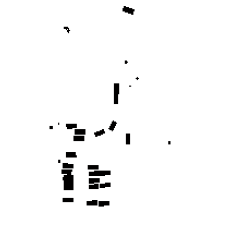

In [12]:
plt.imshow(bev_map)
plt.axis('off')

(-0.5, 199.5, 199.5, -0.5)

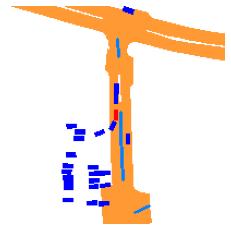

In [13]:
np.unique(data['bev'].numpy())
plt.imshow(bev)
plt.axis('off')

(-0.5, 4799.5, 1799.5, -0.5)

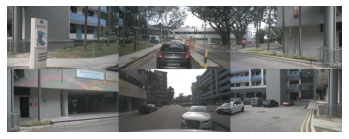

In [14]:
plt.imshow(merged_imgs)
plt.axis('off')